In [1]:
%run function_and_library.ipynb

In [13]:
from datetime import datetime
import pandas as pd

def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()


<ipython-input-13-843b4180e64f>:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./currency_data_10_years.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [18]:
series = series.iloc[:,0]

series_eur = series.resample('3D').mean()

series

date
2013-05-01    12816.661099
2013-05-02    12696.355896
2013-05-03    12735.428571
2013-05-04    12758.622548
2013-05-05    12719.240307
                  ...     
2023-04-27    16209.481958
2023-04-28    16327.538019
2023-04-29    16327.528027
2023-04-30    16152.482580
2023-05-01    16098.499876
Name: EUR, Length: 3653, dtype: float64

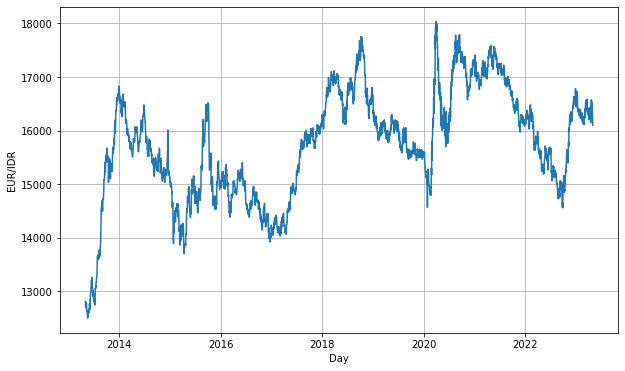

In [19]:
# Preview the data
plot_series(series.index, series, xlabel='Day', ylabel='EUR/IDR')

In [20]:
len(series_eur)

1218

In [24]:
split_time = 1000

x_train = series_eur[:split_time]
time_train = series_eur.index[:split_time]

x_valid = series_eur[split_time:]
time_valid = series_eur.index[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [25]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=[window_size], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
], name="3_days")

# Get initial weights
init_weights = model_1.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model_1.set_weights(init_weights)

model_1.summary()
learning_rate = 1e-10
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_1.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])

# Train the model
history_1 = model_1.fit(train_set,
                      epochs=100,
                      verbose=1,
                      batch_size=batch_size,
                      validation_data=valid_set)

Model: "3_days"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 2s 13ms/step - loss: 2277.7141 - mae: 2276.8174 - val_loss: 483.2767 - val_mae: 482.5863
Epoch 2/100
31/31 [===========================

Epoch 53/100
31/31 [==============================] - 0s 4ms/step - loss: 192.6347 - mae: 192.5713 - val_loss: 149.5682 - val_mae: 149.5050
Epoch 54/100
31/31 [==============================] - 0s 5ms/step - loss: 182.6874 - mae: 182.6243 - val_loss: 325.8503 - val_mae: 325.7873
Epoch 55/100
31/31 [==============================] - 0s 4ms/step - loss: 284.4081 - mae: 284.3449 - val_loss: 359.3760 - val_mae: 359.3136
Epoch 56/100
31/31 [==============================] - 0s 5ms/step - loss: 233.5754 - mae: 233.5123 - val_loss: 170.6447 - val_mae: 170.5827
Epoch 57/100
31/31 [==============================] - 0s 4ms/step - loss: 194.7716 - mae: 194.7091 - val_loss: 434.9798 - val_mae: 434.9179
Epoch 58/100
31/31 [==============================] - 0s 5ms/step - loss: 201.7349 - mae: 201.6731 - val_loss: 147.4450 - val_mae: 147.3836
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 175.1788 - mae: 175.1171 - val_loss: 127.4822 - val_mae: 127.4202
Epoch 60/100
31/31 [

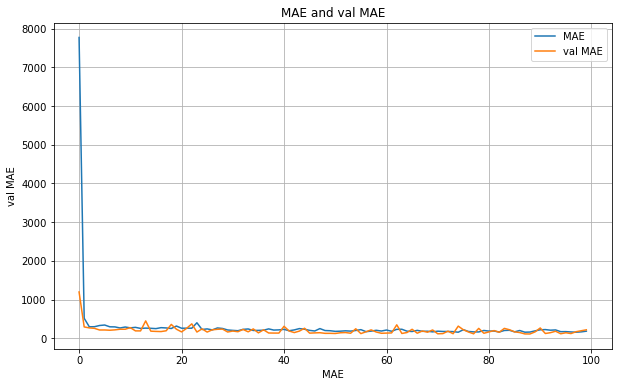

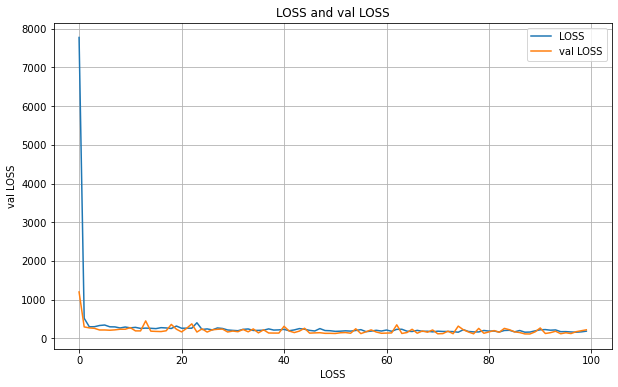

7/7 [==============================] - 0s 10ms/step


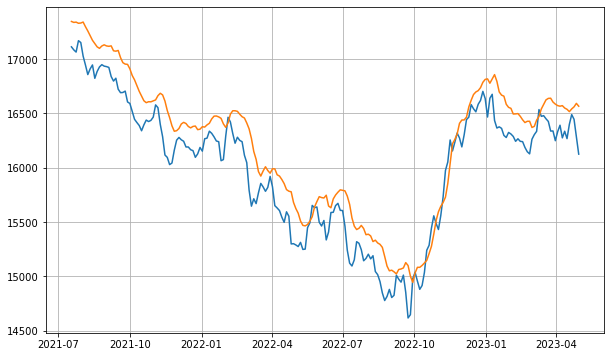

{'mae': 222.03409,
 'mse': 63659.79,
 'rmse': 252.30891,
 'mape': 1.3910557,
 'mase': 3.0552466}

In [55]:
# Get mae and loss from history log
mae=history_1.history['mae']
val_mae=history_1.history['val_mae']
loss=history_1.history['loss']
val_loss=history_1.history['val_loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, val_mae), 
    title='MAE and val MAE', 
    xlabel='MAE',
    ylabel='val MAE',
    legend=['MAE', 'val MAE']
    )

plot_series(
    x=epochs, 
    y=(loss, val_loss), 
    title='LOSS and val LOSS', 
    xlabel='LOSS',
    ylabel='val LOSS',
    legend=['LOSS', 'val LOSS']
    )

# Reduce the original series
forecast_series = series_eur[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model_1, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results_1 = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results_1))

eval_model_1 = evaluate_preds(y_true=x_valid,
                               y_pred=results_1)
eval_model_1

1/1 [==============================] - 0s 31ms/step


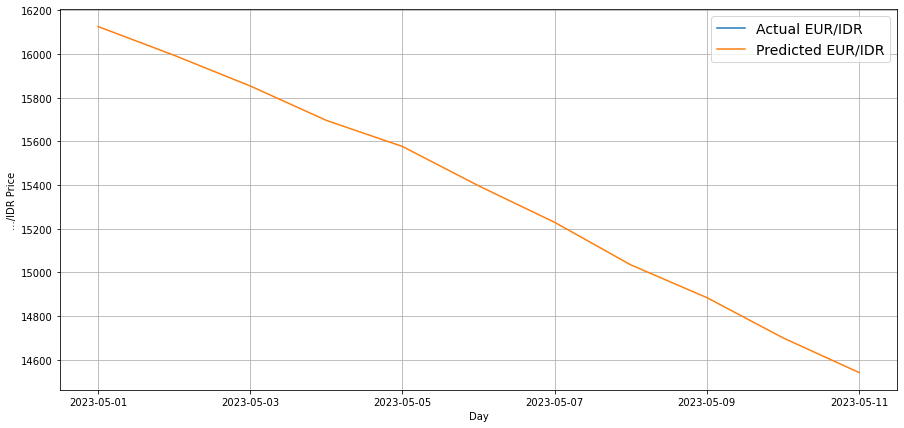

In [26]:
from datetime import timedelta

into_future = 10
future_forecast = make_future_forecast(values=series_eur[:-into_future],
                                       model=model_1,
                                       into_future=into_future,
                                       window_size=window_size)

next_time_steps = pd.date_range(start=series_eur.index[-1] + pd.DateOffset(1), periods=into_future+1)
# next_time_steps = np.insert(next_time_steps, 0, series_eur.index[-1])
future_forecast = np.insert(future_forecast, 0, series_eur[-1])

plt.figure(figsize=(15, 7))
plot_time_series(series_eur.index, series_eur, start=3600, format="-", label="Actual EUR/IDR")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted EUR/IDR")